<a href="https://colab.research.google.com/github/HubertasVin/deep-learning-practice/blob/main/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importuojamos reikalingos bibliotekos

In [14]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from google.colab import drive

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Naudojamas įrenginys:", device)

drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/colab_content'

Naudojamas įrenginys: cuda:0
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Duomenų įkėlimas ir paruošimas

In [15]:
# Naudojame image_dataset_from_directory funkciją, kuri automatiškai padalina duomenis
# į mokymo (training) ir validacijos (validation) aibes pagal nurodytą validacijos split
transforms_train = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

transforms_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

class MyDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Sukuriame sąrašą su visų failų kelių ir jų atitinkamų klasių indeksų
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            if os.path.isdir(cls_dir):
                for file in os.listdir(cls_dir):
                    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(cls_dir, file))
                        self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        # Konvertuojame į RGB, jei reikia
        if image.mode != 'RGB':
            image = image.convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Sukuriame pilną duomenų rinkinį
dataset = MyDataset(DATA_DIR, transform=transforms_train)
print("Viso nuotraukų:", len(dataset))

# Padaliname duomenų rinkinį į mokymo (80%) ir testavimo (20%) aibes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
dataset_train, dataset_test = random_split(dataset, [train_size, test_size])

# Ta testavimo aibė naudosime kitą transformaciją (be duomenų augmentacijos)
dataset_test.dataset.transform = transforms_test

# Sukuriame DataLoader'us
batch_size = 16
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=2)

Viso nuotraukų: 3


Modelio sukūrimas

In [16]:
class Model(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Model, self).__init__()
        # Pirmasis blokas
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Antrasis blokas
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # Pilnai sujungti sluoksniai
        # Skaičiuojame flatten dydį: pradinė nuotraukos dydis 128x128, po dviejų 2x2 pool sluoksnių -> 32x32
        self.fc1 = nn.Linear(128 * 32 * 32, 516)
        self.fc2 = nn.Linear(516, 224)
        self.fc3 = nn.Linear(224, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.relu(self.conv3(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

num_classes = len(dataset.classes)
model = Model(in_channels=3, num_classes=num_classes).to(device)
print("Modelio parametru skaičius:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Modelio parametru skaičius: 67862502


Treniravimo ciklas

In [17]:
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def evaluate(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    return np.array(all_preds), np.array(all_labels)

num_epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
for epoch in range(num_epochs):
    loss = train_one_epoch(model, loader_train, criterion, optimizer)
    train_losses.append(loss)
    preds, labels = evaluate(model, loader_test)
    acc = accuracy_score(labels, preds)
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {loss:.4f} - Test Accuracy: {acc:.4f}")

Epoch 1/10 - Loss: 0.6683 - Test Accuracy: 1.0000
Epoch 2/10 - Loss: 0.0002 - Test Accuracy: 1.0000
Epoch 3/10 - Loss: 0.0000 - Test Accuracy: 1.0000
Epoch 4/10 - Loss: 0.0000 - Test Accuracy: 1.0000
Epoch 5/10 - Loss: 0.0000 - Test Accuracy: 1.0000
Epoch 6/10 - Loss: 0.0000 - Test Accuracy: 1.0000
Epoch 7/10 - Loss: 0.0000 - Test Accuracy: 1.0000
Epoch 8/10 - Loss: 0.0000 - Test Accuracy: 1.0000
Epoch 9/10 - Loss: 0.0000 - Test Accuracy: 1.0000
Epoch 10/10 - Loss: 0.0000 - Test Accuracy: 1.0000


Modelio vertinimas ir metrikų skaičiavimas

In [18]:
preds, labels = evaluate(model, loader_test)
cm = confusion_matrix(labels, preds)
acc = accuracy_score(labels, preds)
prec = precision_score(labels, preds, average='weighted', zero_division=0)
rec = recall_score(labels, preds, average='weighted', zero_division=0)
f1 = f1_score(labels, preds, average='weighted', zero_division=0)

print("\nKlasifikacijos matrica:")
print(cm)
print("Tikslumas:", acc)
print("Precizija:", prec)
print("Atkūrimas:", rec)
print("F1:", f1)


Klasifikacijos matrica:
[[1]]
Tikslumas: 1.0
Precizija: 1.0
Atkūrimas: 1.0
F1: 1.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Treniruotės istorijos vizualizacija

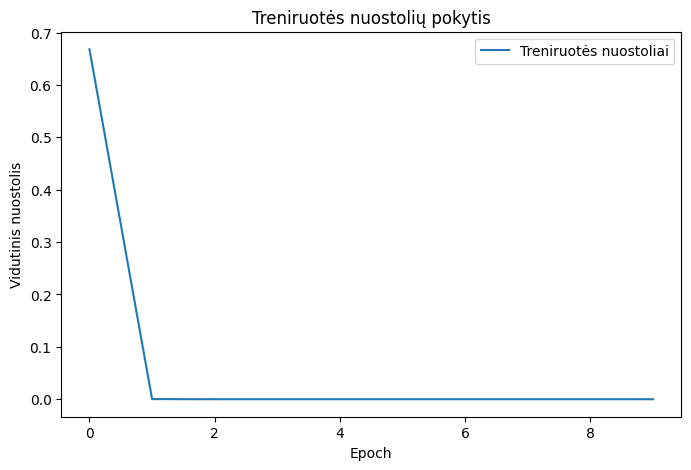

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Treniruotės nuostoliai')
plt.xlabel('Epoch')
plt.ylabel('Vidutinis nuostolis')
plt.title('Treniruotės nuostolių pokytis')
plt.legend()
plt.show()